In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense,Activation,Input,Flatten,Conv2D,MaxPooling2D,concatenate,LSTM
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
import math
import os
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
os.chdir('c:\\Users\\ASUS\\Projects')
#df = pd.read_csv('CI\\Asia_ImportQuantity.csv',encoding='latin-1')
Asia_importQ_Urea = pd.read_csv('Processed_data.csv',index_col='Year')

In [30]:
X = Asia_importQ_Urea['Turkey']
X = np.reshape( pd.DataFrame(X) , (16,1))
X_train = X[:12]
X_test = X[12:]

In [31]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

LSTM Model
---

In [32]:
n_input = 2
n_features = 1
LSTM_generator = TimeseriesGenerator(X_train_scaled, X_train_scaled, length=n_input, batch_size=1)
LSTM_generator_test = TimeseriesGenerator(X_test_scaled, X_test_scaled, length=n_input)

In [33]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer='adam', loss='mse')

In [34]:
LSTM_model.fit_generator(LSTM_generator,epochs=30)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
10/10 [==============================] - 3s 3ms/step - loss: 0.5251
Epoch 2/30
10/10 [==============================] - 0s 3ms/step - loss: 0.3645
Epoch 3/30
10/10 [==============================] - 0s 3ms/step - loss: 0.2309
Epoch 4/30
10/10 [==============================] - 0s 3ms/step - loss: 0.2022
Epoch 5/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1442
Epoch 6/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0960
Epoch 7/30
10/10 [==============================] - 0s 4ms/step - loss: 0.1452
Epoch 8/30
10/10 [==============

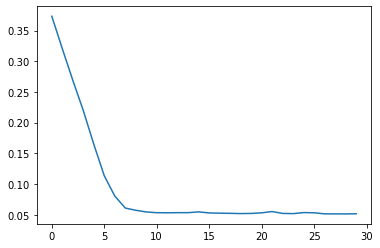

In [35]:
LSTM_loss_per_epoch = LSTM_model.history.history['loss']
plt.plot(range(len(LSTM_loss_per_epoch)),LSTM_loss_per_epoch)


In [36]:
LSTM_test_predictions = []

first_LSTM_eval_batch = X_train_scaled[-n_input:]
current_LSTM_batch = first_LSTM_eval_batch.reshape((1, n_input, n_features))

for i in range(len(X_test)):
    current_LSTM_pred = LSTM_model.predict(current_LSTM_batch)[0]
    LSTM_test_predictions.append(current_LSTM_pred)
    current_LSTM_batch = np.append(current_LSTM_batch[:,1:,:],[[current_LSTM_pred]],axis=1)

In [37]:
true_LSTM_predictions = scaler.inverse_transform(LSTM_test_predictions)

In [40]:
LSTM_model.evaluate_generator(LSTM_generator_test)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1.3916652202606201

In [41]:
LSTM_model.evaluate_generator(LSTM_generator)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.05033209174871445

In [19]:
np.sqrt(mean_squared_error(X_test['Turkey'],X_test['LSTM_Prediction']))

876220.0181477553

In [42]:
def convertToDataset(data, step):
    #data = np.append(data,np.repeat(data[-1,],step))
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [43]:
country_dict = {}
i = 0
for (columnName,columnData) in Asia_importQ_Urea.iteritems():
    country_dict[columnName] = i
    i = i+1

In [96]:
def predict_lstm_country(country_name):
    x = np.reshape(pd.DataFrame(Asia_importQ_Urea[country_name]),(16,1))
    xTrain = x.iloc[:12]
    xTest = x.iloc[12:]
    MMS = list(np.zeros(35))
    MMS[country_dict[country_name]] = MinMaxScaler()
    MMS[country_dict[country_name]].fit(xTrain)
    train_scaled = MMS[country_dict[country_name]].transform(xTrain)
    test_scaled = MMS[country_dict[country_name]].transform(xTest)

    trainX,trainY =convertToDataset(train_scaled,2)
    testX,testY =convertToDataset(test_scaled,2)

    trainX = np.reshape(trainX, (trainX.shape[0],  trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0],testX.shape[1], 1))

    lstm = list(np.zeros(35))
    lstm[country_dict[country_name]] = Sequential()
    lstm[country_dict[country_name]].add(LSTM(150, activation='relu'))
    lstm[country_dict[country_name]].add(Dense(1))
    lstm[country_dict[country_name]].compile(optimizer='adam', loss='mse')

    history = []
    history.append(lstm[country_dict[country_name]].fit(trainX,trainY, epochs=50, batch_size=1, verbose=2))

    testx_predictions= lstm[country_dict[country_name]].predict(testX)
    testy_predictions = lstm[country_dict[country_name]].predict(np.reshape(testY,(1,2,1)))

    true_predictions = MMS[country_dict[country_name]].inverse_transform(np.reshape(np.append(testx_predictions,testy_predictions),(3,1)))
    new_test = xTest[:-1]
    new_test['pred'] = true_predictions
    new_test.plot()

    train_score = lstm[country_dict[country_name]].evaluate(trainX,trainY)
    test_score = lstm[country_dict[country_name]].evaluate(testX,testY)
    print('Test Score is :', test_score,'\n Train Score is :',train_score)

    from sklearn.metrics import mean_squared_error
    print('\n MSE : ',np.sqrt(mean_squared_error(new_test[country_name],new_test['pred'])))

Epoch 1/50
10/10 - 2s - loss: 0.4790
Epoch 2/50
10/10 - 0s - loss: 0.4090
Epoch 3/50
10/10 - 0s - loss: 0.3447
Epoch 4/50
10/10 - 0s - loss: 0.2903
Epoch 5/50
10/10 - 0s - loss: 0.2298
Epoch 6/50
10/10 - 0s - loss: 0.1729
Epoch 7/50
10/10 - 0s - loss: 0.1301
Epoch 8/50
10/10 - 0s - loss: 0.1060
Epoch 9/50
10/10 - 0s - loss: 0.0826
Epoch 10/50
10/10 - 0s - loss: 0.0833
Epoch 11/50
10/10 - 0s - loss: 0.0828
Epoch 12/50
10/10 - 0s - loss: 0.0827
Epoch 13/50
10/10 - 0s - loss: 0.0838
Epoch 14/50
10/10 - 0s - loss: 0.0831
Epoch 15/50
10/10 - 0s - loss: 0.0866
Epoch 16/50
10/10 - 0s - loss: 0.0818
Epoch 17/50
10/10 - 0s - loss: 0.0811
Epoch 18/50
10/10 - 0s - loss: 0.0817
Epoch 19/50
10/10 - 0s - loss: 0.0812
Epoch 20/50
10/10 - 0s - loss: 0.0818
Epoch 21/50
10/10 - 0s - loss: 0.0820
Epoch 22/50
10/10 - 0s - loss: 0.0817
Epoch 23/50
10/10 - 0s - loss: 0.0844
Epoch 24/50
10/10 - 0s - loss: 0.0805
Epoch 25/50
10/10 - 0s - loss: 0.0803
Epoch 26/50
10/10 - 0s - loss: 0.0817
Epoch 27/50
10/10 - 0

<ipython-input-96-969c78f2d04d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test['pred'] = true_predictions


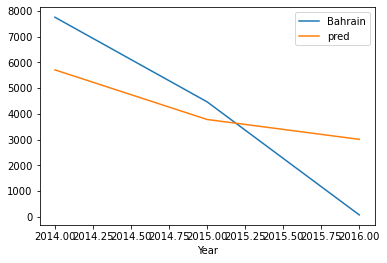

In [98]:
predict_lstm_country('Bahrain')
